<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=300 HEIGHT=200>



<CENTER>
</br>
<p><font size="4"> UE Big Data and Cloud computing for climate - 2024</span></p>
<p></p>
<p><font size="5">  Project 8 - The North Atlantic Multidecadal Oscillation (AMO) </font></p>
<p><font size="4">  Students: Daniel Tapia, Cecilia Florenza, Vanessa Tosello and Zoé Remita </font></p>
</p></br>
</p>
</CENTER>

--------

## Environment setup

In [191]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip install cftime

# and set up Cartopy
!pip uninstall shapely --yes

# note: the next step produces an error in pip. You can ignore this error.
!pip install lida==0.0.10 shapely cartopy --no-binary shapely --no-binary cartopy --use-deprecated=legacy-resolver

# and manually download shape files for Cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/main/lib/cartopy/feature/download/__main__.py -O cartopy_feature_download.py
!python cartopy_feature_download.py physical

In [192]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline

## Data Catalogue
Now let's look at the available data in the catalogue, and select one of the simulations:

* **source_id**: name of the specific climate model that produced the data
* **experiment_id**: climate change scenario or experiment that the data represents. For example, `ssp126` represents a low-emissions scenario, while `ssp585` represents a high-emissions scenario
* **member_id**: climate models are often run multiple times with slight variations in initial conditions to produce an ensemble of simulations
* **table_id**: type of data and its output frequency. `Omon` refers to monthly data related to the ocean
* **variable_id**: particular climate variable represented in the data. For example, `tos` stands for sea surface temperature, while `zos` represents sea surface height

In [193]:
# read in the catalogue information
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# look for simulations that correspond to our chosen criteria
df_ssh = df.query("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'zos' & experiment_id == 'ssp245' & institution_id == 'IPSL'")

experiment_ids = ['ssp126', 'ssp245', 'ssp370', 'ssp460', 'ssp585', 'historical']
df_ipsl = df.query(
    "source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1' & experiment_id in @experiment_ids & "
    "((table_id == 'Omon' & variable_id in ['tos', 'tosga']) | (table_id == 'Ofx' & variable_id == 'areacello'))"
)
df_ipsl

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
27255,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
28696,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tosga,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
28719,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
47360,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r1i1p1f1,Omon,tosga,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
47361,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
47849,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
48156,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
48392,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r1i1p1f1,Omon,tosga,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
48393,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
198356,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp460,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190506


The table shows multiple available outputs for the same forcing scenario and model: these are the different members (member_id column) of the ensemble for that model and scenario. Now let's select one of the members:

In [194]:
def get_data(experiment_id, variable_id, df_ipsl):
    """
    Retrieves data from a Zarr store for a given experiment_id and variable_id.

    Parameters:
        experiment_id (str): The experiment identifier (e.g., 'ssp126').
        variable_id (str): The variable identifier (e.g., 'tos' or 'areacello').
        df_ipsl (pd.DataFrame): The dataframe containing the information from the catalogue.

    Returns:
        xarray.Dataset: The dataset corresponding to the Zarr store for the given experiment_id and variable_id.
    """
    # Filter the dataframe based on the experiment_id and variable_id
    df = df_ipsl.query(
        "experiment_id == @experiment_id & variable_id == @variable_id"
    )

    if df.empty:
        print(f"No data found for experiment_id: {experiment_id} and variable_id: {variable_id}")
        return None

    # Access the first Zarr store
    zstore = df.zstore.values[0]
    print(f"Processing zstore: {zstore} for experiment_id: {experiment_id}, variable_id: {variable_id}")

    # Set up access to GCS
    gcs = gcsfs.GCSFileSystem(token='anon')

    # Create a mapper for the Zarr store
    mapper = gcs.get_mapper(zstore)

    # Open the dataset with xarray
    ds = xr.open_dataset(zstore, decode_times=True, consolidated=True, engine='zarr',
                     backend_kwargs={"storage_options": { "token": 'anon',  'access':'read_only'}})

    return ds

## Retreving Data

We worked with three different Shared Socioeconomic Pathways (SSPs), which represent varying levels of future greenhouse gas emissions and socioeconomic development. These scenarios provide a range of potential climate futures:


*   **ssp126**: A low-emissions scenario with a shift towards sustainability, resulting in a peak and decline in global warming.
*   **ssp370**: An intermediate scenario where emissions stabilize mid-century, leading to continued warming.
*   **ssp585**: A high-emissions scenario with fossil-fuel-intensive development and significant warming.  



For each **SSP scenario** (ssp126, ssp370, and ssp585), we retrieved three key variables from the climate model output using the get_data function:

* **tosga**: This represents the Global Sea Surface Temperature Average and gives us an indicator of overall ocean warming trends.  
* **tos**: This variable provides the Sea Surface Temperature on a gridded map, allowing us to analyze spatial patterns of temperature changes.  
* **areacello**: This variable contains the area of each grid cell in the ocean model. It is necessary for calculating area-weighted averages and ensuring accurate spatial analysis.  

These three variables form the basis for our investigation into the AMO and its behavior under different climate scenarios.
<!-- By examining their evolution over time and their relationships with each other, we aim to gain insights into the AMO's influence on the North Atlantic region.  -->






In [195]:
# select SSP scenario
i = 126 # 370 or 585
experiment_id = f'ssp{i}'
ipsl_ssp126_tosga = get_data(experiment_id, 'tosga', df_ipsl)
ipsl_ssp126_tos = get_data(experiment_id, 'tos', df_ipsl)
ipsl_ssp126_areacello = get_data(experiment_id, 'areacello', df_ipsl)


Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p1f1/Omon/tosga/gn/v20190903/ for experiment_id: ssp126, variable_id: tosga


/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/core/indexing.py:511: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p1f1/Omon/tos/gn/v20190903/ for experiment_id: ssp126, variable_id: tos
Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p1f1/Ofx/areacello/gn/v20190903/ for experiment_id: ssp126, variable_id: areacello


### Plotting retrieved data

### Tosga

In [196]:
ipsl_ssp126_tosga

<xarray.Dataset> Size: 96kB
Dimensions:         (y: 1, x: 1, nvertex: 4, time: 3432, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 16B ...
    bounds_nav_lon  (y, x, nvertex) float32 16B ...
    nav_lat         (y, x) float32 4B ...
    nav_lon         (y, x) float32 4B ...
  * time            (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:...
    time_bounds     (time, axis_nbounds) object 55kB ...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 4B ...
    tosga           (time, y, x) float32 14kB ...
Attributes: (12/51)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  ssp126
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    table_id:               Omon
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / Sc...
    tracking_id:            hdl:21.14100/1e4753bb-b492-465b-9754-634f18ff6235...
    variable_id:            tosga
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r1i1p1f1

Since the `tos` variable contains 1032 time steps representing monthly data over 86 years, we need to truncate the `tosga` variable, which originally has 3432 time steps representing monthly data over 286 years, to match the temporal extent of `tos`.

In [197]:
ipsl_ssp126_tosga_truncated = ipsl_ssp126_tosga.isel(time=slice(0,1032))
ipsl_ssp126_tosga_truncated['time']=ipsl_ssp126_tos.time

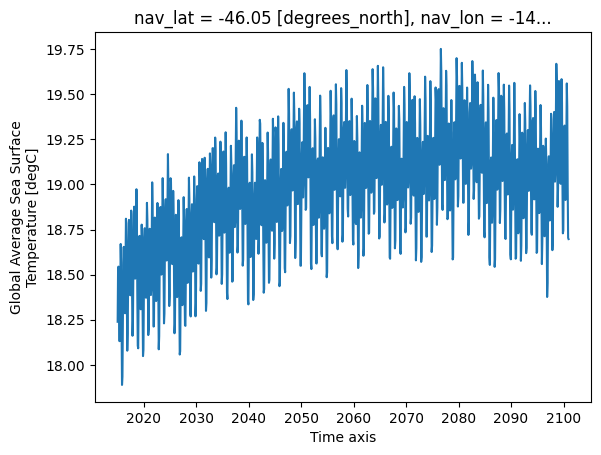

In [198]:
ipsl_ssp126_tosga_truncated.tosga.plot()

### Tos

In [199]:
ipsl_ssp126_tos

<xarray.Dataset> Size: 501MB
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1032, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 2MB ...
    bounds_nav_lon  (y, x, nvertex) float32 2MB ...
    nav_lat         (y, x) float32 481kB ...
    nav_lon         (y, x) float32 481kB ...
  * time            (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12...
    time_bounds     (time, axis_nbounds) datetime64[ns] 17kB ...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 481kB ...
    tos             (time, y, x) float32 496MB ...
Attributes: (12/52)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  ssp126
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / Sc...
    tracking_id:            hdl:21.14100/fc941f96-e04a-4757-bed0-f89f1669a4a1
    variable_id:            tos
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r1i1p1f1
    status:                 2019-11-09;created;by nhn2@columbia.edu

Latitude is called ```nav_lat``` in this model, and longitude is called ```nav_lon```. Now we'll select only the North Atlantic region. We'll choose the region 80°W to 0°E, 0 to 60°N:

In [200]:
lat_tos = ipsl_ssp126_tos.nav_lat.compute()
lon_tos = ipsl_ssp126_tos.nav_lon.compute()
ipsl_ssp126_tos = ipsl_ssp126_tos.where(((lat_tos > 0) & (lat_tos < 60) & (lon_tos > -80) & (lon_tos < 0)),drop=True)
lat_area = ipsl_ssp126_areacello.nav_lat.compute()
lon_area = ipsl_ssp126_areacello.nav_lon.compute()
ipsl_ssp126_areacello = ipsl_ssp126_areacello.where(((lat_area > 0) & (lat_area < 60) & (lon_area > -80) & (lon_area < 0)),drop=True)

Now let's see what happens if we try to plot a map for a specific date

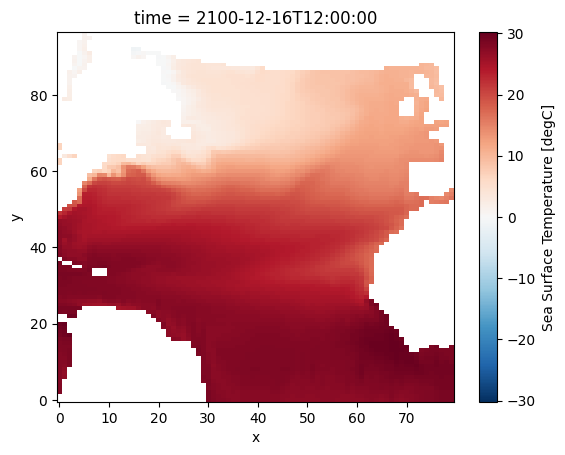

In [201]:
ipsl_ssp126_tos.tos.sel(time=ipsl_ssp126_tos.time[-1]).squeeze().plot()

It's not so easy to see what's going on with this simple map. We can make the map easier to read by choosing a [projection](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections), centering the map on the North Atlantic region, and adding some coastlines. Without adding any data, our map will then look like this:

To be able to plot our data on this map, we also need to apply a transformation. We can just tell xarray to do this for us, by telling it the name of the transformation to apply:

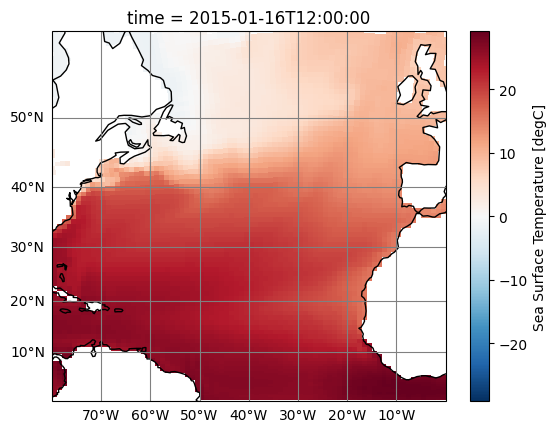

In [202]:
# first we set up our axes with the projection that we want
ax = plt.axes(projection=ccrs.Mercator());
# then we set the latitude and longitude limits on our figure
# ([west_longitude,east_longitude,south_latitude,north_latitude])
ax.set_extent([-80, 0, 0, 60], ccrs.PlateCarree())
# now we tell xarray to plot our data. We pass a number of extra parameters:
# transform=ccrs.PlateCarree() -> tells xarray how to transform the data
# x='nav_lon' -> tells xarray the name of the longitude variable
# y='nav_lat' -> tells xarray the name of the latitude variable
ipsl_ssp126_tos.tos[0].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='nav_lon', y='nav_lat', add_colorbar=True);
# finally, we add the coastlines
ax.coastlines();
# and add grid lines
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey')
# by default, labels are placed on both the right and left hand sides of the
# figure, and at both the top and bottom. The commands below turn off the
# labels on the right hand side, and on the top
gl.right_labels = False
gl.top_labels = False

### Areacello

In [203]:
ipsl_ssp126_areacello

<xarray.Dataset> Size: 372kB
Dimensions:         (y: 97, x: 80, nvertex: 4)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 124kB ...
    bounds_nav_lon  (y, x, nvertex) float32 124kB ...
    nav_lat         (y, x) float32 31kB 0.3333 0.3333 0.3333 ... 63.76 63.59
    nav_lon         (y, x) float32 31kB -79.5 -78.5 -77.5 ... 3.672 4.85 6.018
Dimensions without coordinates: y, x, nvertex
Data variables:
    area            (y, x) float32 31kB 4.121e+09 4.121e+09 ... nan nan
    areacello       (y, x) float32 31kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/51)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  ssp126
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    table_id:               Ofx
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / Sc...
    tracking_id:            hdl:21.14100/c264490b-d2dc-4810-8bc0-4560e788cbf3
    variable_id:            areacello
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r1i1p1f1

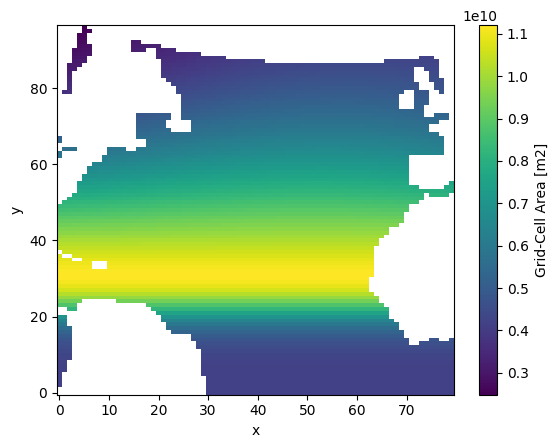

In [204]:
ipsl_ssp126_areacello.areacello.squeeze().plot()

## 1. First step: defining the AMO index

### 1.1 Calculate the North Atlantic SSTA


We calculate the area-weighted average sea surface temperature (SST) for the North Atlantic, denoted by `A`. This is done by multiplying the SST values (`tos`) by the corresponding grid cell areas (`areacello`) and then dividing by the total area of the North Atlantic. This weighting ensures that larger grid cells contribute more to the average SST calculation.


$$A = \frac{\text{sst}(x, y) \cdot \text{areacello}(x, y)}{\text{area}}$$

* **Local SST**: We obtain the SST values (sst) from the `tos` variable, which provides SST at each point (x, y) on the grid covering the North Atlantic.
<!-- These values are represented by `tos(x, y)`.   -->
* **Grid cell area**: We also consider the area of each grid cell, denoted by `areacello(x, y)`. This accounts for the fact that different grid cells may represent areas of different size.  
* **Weighting**: To obtain a weighted mean, we multiply the SST at each point by the corresponding grid cell area: `tos(x, y) ⋅ areacello(x, y)`.  
* **Summing**: We sum these weighted values across all grid points in the North Atlantic region.  
* **Normalization**: We divide this sum by the total area of the North Atlantic region (`area`) to obtain the weighted mean, which is A.


##### Area-weighted sea surface temperature average

In [205]:
total_area = ipsl_ssp126_areacello.areacello.sum(dim=['x', 'y'])
ds_weighted= (ipsl_ssp126_areacello.areacello * ipsl_ssp126_tos.tos ) / total_area
A = ds_weighted.sum(dim=['x', 'y'])
A


<xarray.DataArray (time: 1032)> Size: 4kB
array([18.801796, 18.322676, 18.334467, ..., 23.744015, 22.039576,
       20.441635], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T12:...

Text(0, 0.5, 'SST (°C)')

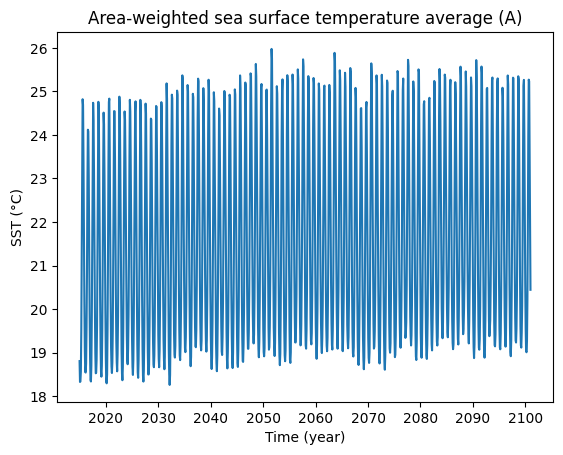

In [206]:
A.plot()
plt.title("Area-weighted sea surface temperature average (A)")
plt.xlabel("Time (year)")
plt.ylabel("SST (°C)")

$$A = \text{AMO} + \text{climate change} + \text{seasonal cycle} + \text{random variable}$$


This equation represents the different components that contribute to the area-weighted average sea surface temperature (SST) in the North Atlantic, denoted by A. These components are:

* **AMO**: The North Atlantic Multidecadal Oscillation, a natural climate pattern we aim to isolate.
* **Climate change**: The long-term trend of increasing global temperatures.
* **Seasonal cycle**: The regular annual pattern of SST variation.
* **Random variable**: Unpredictable fluctuations in SST.


#### Removing the seasonal cycle:



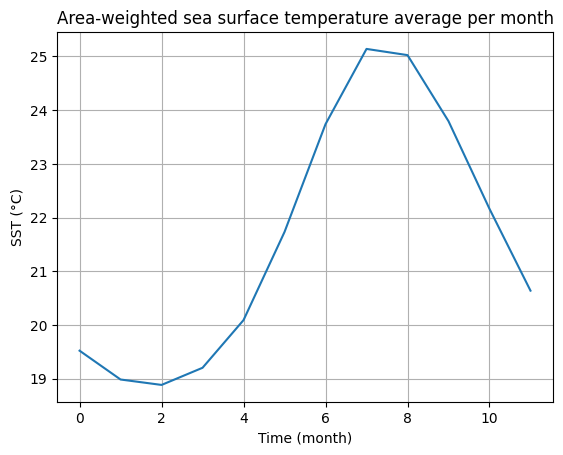

In [207]:
monthly_mean = A.groupby('time.month').mean(dim='time')

# Plot
plt.plot(monthly_mean)
plt.title("Area-weighted sea surface temperature average per month")
plt.xlabel("Time (month)")
plt.ylabel("SST (°C)")
plt.grid(True)

Text(0, 0.5, 'SST (°C)')

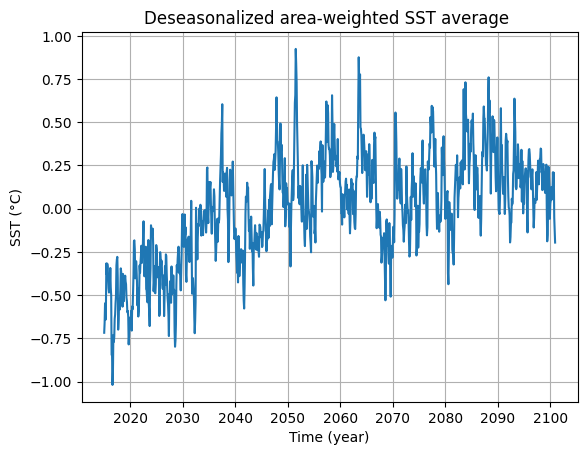

In [208]:
deseasonalized_A = A.groupby('time.month') - monthly_mean

# Plot
deseasonalized_A.plot()
plt.grid(True)
plt.title("Deseasonalized area-weighted SST average ")
plt.xlabel("Time (year)")
plt.ylabel("SST (°C)")


By subtracting the seasonal cycle from both sides of the equation, we get:

$$A - \text{seasonal cycle} = \text{AMO} + \text{climate change} + \text{random variable}$$

This new equation shows that by removing the seasonal cycle from A, we are left with a time series that primarily reflects the combined influence of the AMO, climate change, and random variability. This step is crucial for isolating the AMO signal and studying its characteristics.

### 1.2 Calculate the Global SSTA

To account for the natural annual variation in global SST, we calculate the seasonal cycle of `tosga` by determining the average SST for each calendar month over the entire time period. This monthly climatology is then subtracted from the original `tosga` data, resulting in the global **Sea Surface Temperature Anomaly** (SSTA).

$$\text{SSTA} = \text{Global SST Average} - \text{Seasonal Cycle}$$

The SSTA represents deviations from the expected seasonal pattern, allowing us to focus on longer-term trends and variations in global SST, which are relevant to our analysis of the AMO.




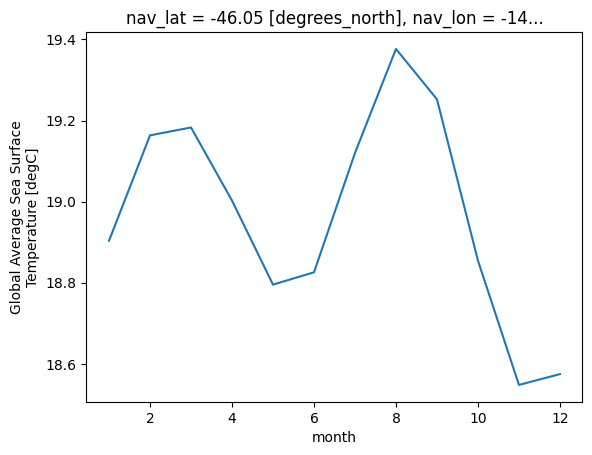

In [209]:
monthly_mean_G = ipsl_ssp126_tosga_truncated.tosga.groupby('time.month').mean(dim='time')
deseasonalized_G = ipsl_ssp126_tosga_truncated.tosga.groupby('time.month') - monthly_mean_G

monthly_mean_G.plot()

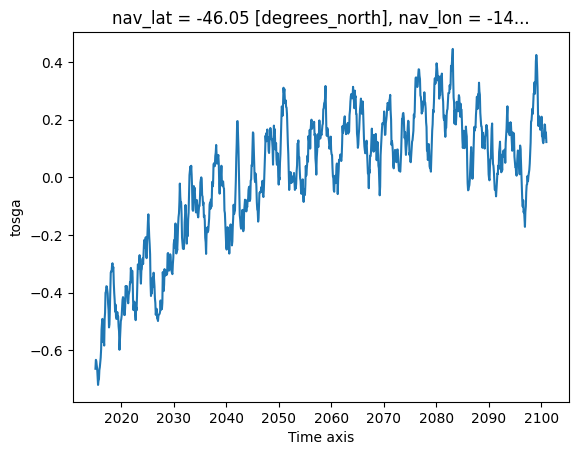

In [210]:
deseasonalized_G.plot()

### 1.3 Remove the Global Warming Signal


To isolate the AMO index, we need to remove the influence of long-term climate change, which is primarily reflected in the global average sea surface temperature (SST) anomalies (`tosga`). This will leave just the "natural" part of the variability.  


$$ A' = A - \text{tosga}  = \text{AMO} + \text{random variable} $$


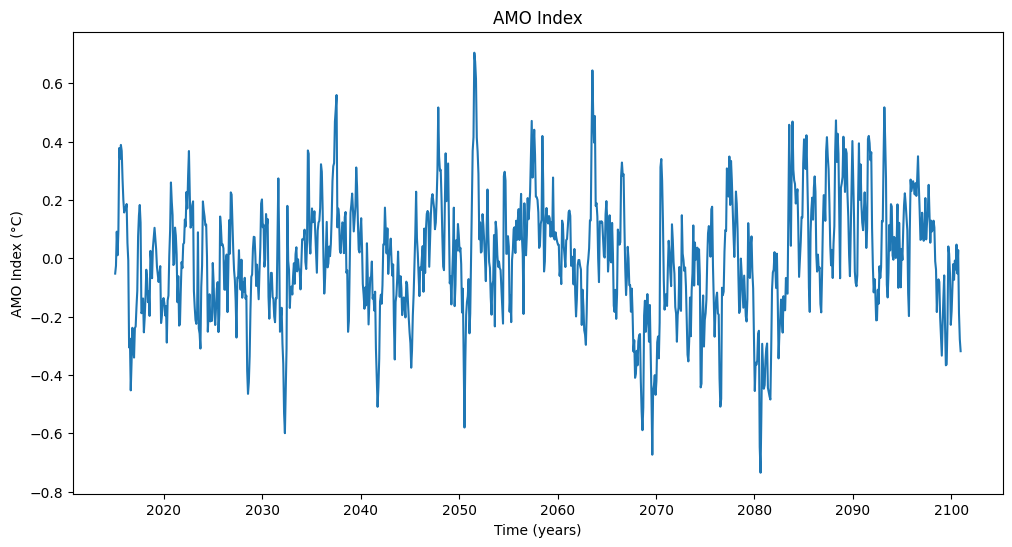

In [211]:
deseasonalized_G_trimmed = deseasonalized_G[:len(deseasonalized_A)]  # Use the first 1032 values

AMO_index = deseasonalized_A - deseasonalized_G_trimmed #+ deseasonalized_G_trimmed.mean()  # Subtract the deseasonalized global SST from North Atlantic SST

# Plot
plt.figure(figsize=(12, 6))
AMO_index.plot()
plt.title("AMO Index")
plt.xlabel("Time (years)")
plt.ylabel("AMO Index (°C)")
plt.show()

### 1.4 Apply a 10-year low-pass filter

We apply a 10-year low-pass filter to the AMO index using the rolling method to smooth the time series and emphasize the multidecadal variability characteristic of the AMO. This filter reduces short-term fluctuations, making the longer-term AMO signal more prominent and easier to interpret.

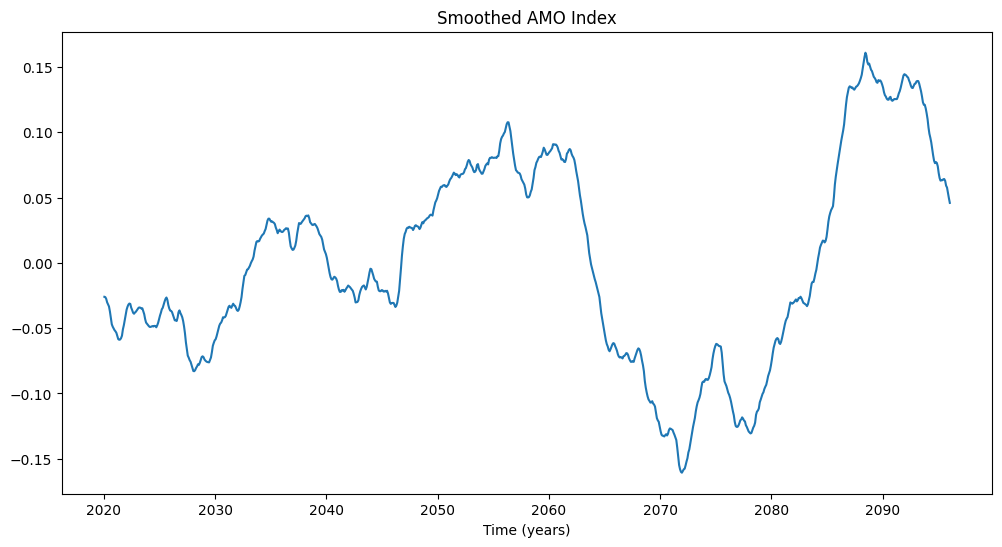

In [212]:
AMO_index_smoothed = AMO_index.rolling(time = 120, center = True).mean() # xarray

# Plot
plt.figure(figsize=(12, 6))
AMO_index_smoothed.plot()
plt.title("Smoothed AMO Index")
plt.xlabel("Time (years)")
plt.show()

Text(0, 0.5, 'SST Anomalies')

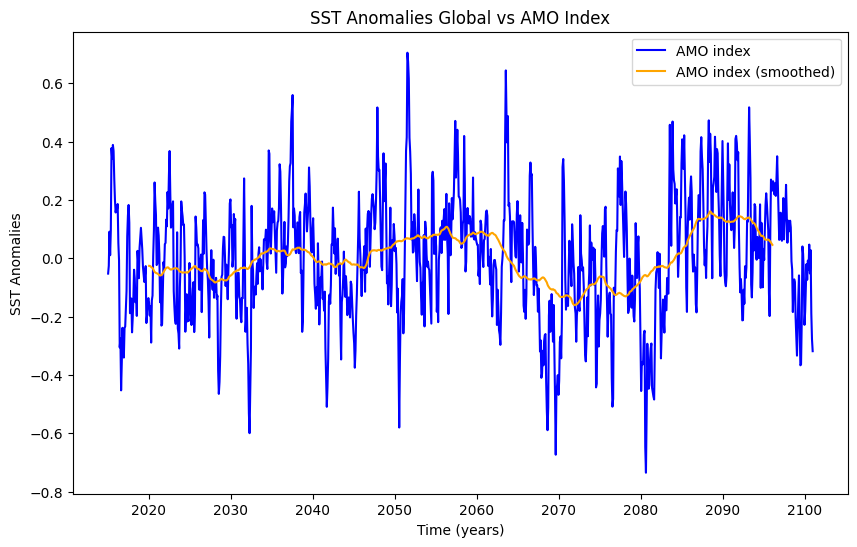

In [213]:
plt.figure(figsize=(10, 6))
plt.plot(AMO_index.squeeze().time, AMO_index.squeeze(), label='AMO index', color='blue')
plt.plot(AMO_index_smoothed.squeeze().time, AMO_index_smoothed.squeeze(), label="AMO index (smoothed)", color='orange')
plt.legend()
plt.title('SST Anomalies Global vs AMO Index')
plt.xlabel('Time (years)')
plt.ylabel('SST Anomalies')

<ipython-input-214-2e2a3f73fd24>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


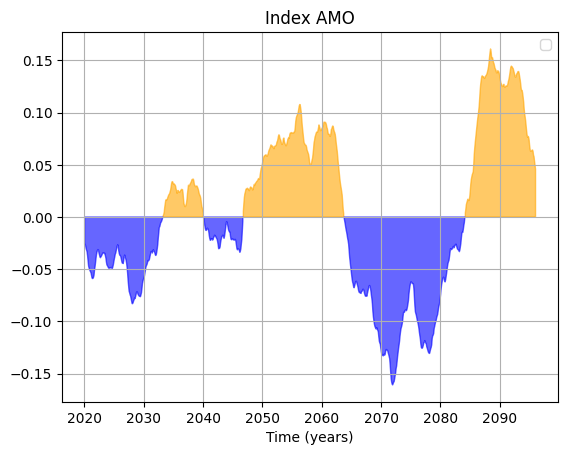

In [214]:
# Fill the positive areas (in orange)
plt.fill_between(
    AMO_index_smoothed.squeeze().time,
    AMO_index_smoothed.squeeze(),
    where=AMO_index_smoothed.squeeze() > 0,
    color="orange",
    alpha=0.6,
)

# Fill the negative areas (in blue)
plt.fill_between(
    AMO_index_smoothed.squeeze().time,
    AMO_index_smoothed.squeeze(),
    where=AMO_index_smoothed.squeeze() <= 0,
    color="blue",
    alpha=0.6,
)

plt.legend()
plt.title("Index AMO")
plt.xlabel("Time (years)")
plt.grid(True)
plt.show()

In [215]:
# save amo index in file
AMO_index.to_netcdf(f'AMO_index_{i}.nc')

## 2. Second step: calculating the AMO pattern

### 2.1 Linear Regression with Global SSTA

In [216]:
monthly_mean_tos = ipsl_ssp126_tos.tos.groupby('time.month').mean(dim='time')

deseasonalized_tos = ipsl_ssp126_tos.tos.groupby('time.month') - monthly_mean_tos  # Subtract climatology from `tosga`

In [217]:
# create a new xarray Dataset, where the dimension variable is the
# variable that we want to use to make our predictions (the global SST).
ds_regression = xr.Dataset({'tos': (('tosga','y','x'), deseasonalized_tos.values)},
                 coords={'tosga': ('tosga', np.ravel(deseasonalized_G.values))})
# linear regression:
sst_coeffs = ds_regression.polyfit('tosga', 1)

### 2.2 Estimate Local SST Changes



In [218]:
# predict the North Atlantic SST at each point as a function
# of the global SST using these coefficients
tfit = xr.polyval(ds_regression.tosga, sst_coeffs)

tfit = tfit.rename_dims({'tosga': 'time'})

tfit['tosga'] = ('time', ipsl_ssp126_tosga_truncated['time'].values)
tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})

<ipython-input-218-df21b55825ec>:8: UserWarning: rename 'tosga' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})


### 2.3 Remove Global SST Signature

In [219]:
# Finally, we can subtract this estimate from the original data
ipsl_ssp126_tos['tos'] = ipsl_ssp126_tos['tos'] - tfit['tos']

array([  1.66532598, -10.1307966 ])

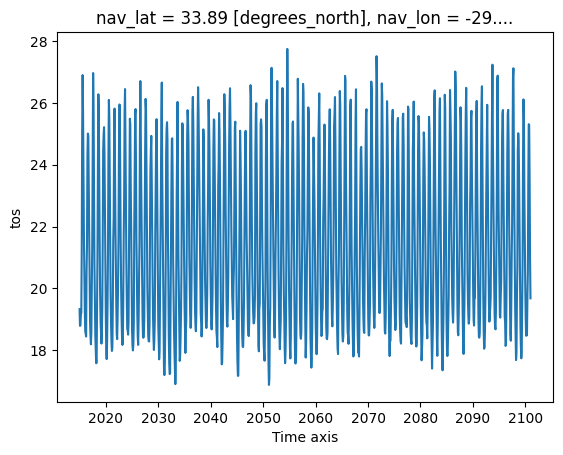

In [220]:
ipsl_ssp126_tos.isel(x=50, y=50).tos.plot()
np.polyfit(np.ravel(ipsl_ssp126_tosga_truncated.tosga.values), ipsl_ssp126_tos.isel(x=50, y=50).tos.values, deg=1)

### 2.4 Linear Regression with AMO Index

In [221]:
ds_regression = xr.Dataset({'tos': (('amo','y','x'), deseasonalized_tos.values)},
                 coords={'amo': ('amo', np.ravel(AMO_index.values))})
ds_regression = ds_regression.isel(amo = slice(61,-59))
sst_coeffs = ds_regression.polyfit('amo', 1)

tfit = xr.polyval(ds_regression.amo, sst_coeffs)
tfit = tfit.rename_dims({'amo': 'time'})

tfit['amo'] = ('time', ipsl_ssp126_tosga_truncated['time'].isel(time =slice(61,-59)).values)
tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'amo': 'time'})

ipsl_ssp126_tos['tos'] = ipsl_ssp126_tos['tos'].isel(time =slice(61,-59) ) - tfit['tos']

<ipython-input-221-ea925cf15a11>:10: UserWarning: rename 'amo' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'amo': 'time'})


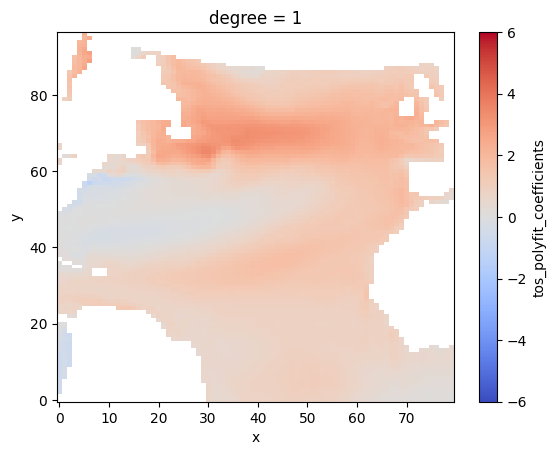

In [222]:
sst_coeffs.sel(degree=1).tos_polyfit_coefficients.plot(cmap="coolwarm", vmin=-6, vmax=6)

In [223]:
# save sst_coeffs in file
sst_coeffs.to_netcdf(f'carte_{i}.nc')

In [224]:
sst_coeffs.sel(degree=1).tos_polyfit_coefficients.mean()

<xarray.DataArray 'tos_polyfit_coefficients' ()> Size: 8B
array(1.0680815)
Coordinates:
    degree   int64 8B 1

## Working with saved files

---

In [225]:
amo_ix_126=xr.open_dataset('AMO_index_126.nc')
amo_ix_370=xr.open_dataset('AMO_index_370.nc')
amo_ix_585=xr.open_dataset('AMO_index_585.nc')

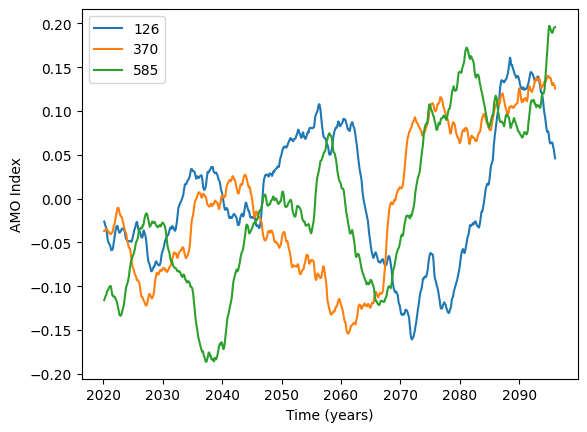

In [226]:

AMO_index_smoothed_126 = amo_ix_126.rolling(time = 120, center = True).mean().isel(time=slice(61,-59)) # xarray
AMO_index_smoothed_370 = amo_ix_370.rolling(time = 120, center = True).mean().isel(time=slice(61,-59)) # xarray
AMO_index_smoothed_585 = amo_ix_585.rolling(time = 120, center = True).mean().isel(time=slice(61,-59)) # xarray

amo_126 = np.ravel(AMO_index_smoothed_126.__xarray_dataarray_variable__)
amo_370 = np.ravel(AMO_index_smoothed_370.__xarray_dataarray_variable__)
amo_585 = np.ravel(AMO_index_smoothed_585.__xarray_dataarray_variable__)

plt.plot(amo_ix_126['time'].isel(time=slice(61,-59)), amo_126, label='126')
plt.plot(amo_ix_370['time'].isel(time=slice(61,-59)), amo_370, label='370')
plt.plot(amo_ix_585['time'].isel(time=slice(61,-59)), amo_585, label='585')

plt.xlabel('Time (years)')
plt.ylabel('AMO Index')
plt.legend()
plt.show()

In [227]:
print(amo_126.mean(), amo_370.mean(), amo_585.mean())

0.0010942252755862228 -0.005626965911067711 -0.007343084090634391


In [228]:
carte_126=xr.open_dataset('carte_126.nc')
carte_370=xr.open_dataset('carte_370.nc')
carte_585=xr.open_dataset('carte_585.nc')

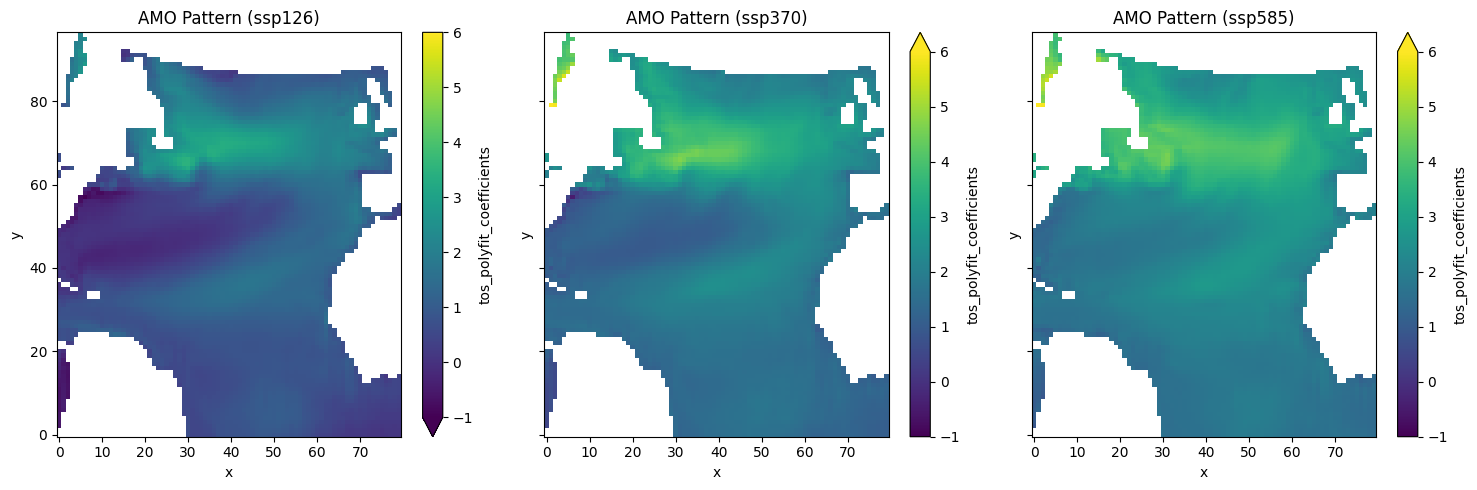

In [229]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

cartes_data = [
    (carte_126.sel(degree=1).tos_polyfit_coefficients, "ssp126"),
    (carte_370.sel(degree=1).tos_polyfit_coefficients, "ssp370"),
    (carte_585.sel(degree=1).tos_polyfit_coefficients, "ssp585"),
]

for i, (data, label) in enumerate(cartes_data):
    ax = axes[i]

    data.plot(ax=ax, vmin=-1, vmax=6)

    ax.set_title(f"AMO Pattern ({label})")

plt.tight_layout()
plt.show()

In [230]:
i=126
experiment_id = f'ssp{i}'
ipsl_ssp126_tosga = get_data(experiment_id, 'tosga', df_ipsl)
ipsl_ssp126_tosga_truncated = ipsl_ssp126_tosga.isel(time=slice(0,1032))
ipsl_ssp126_tosga_truncated['time']=ipsl_ssp126_tos.time

i=370
experiment_id = f'ssp{i}'
ipsl_ssp370_tosga = get_data(experiment_id, 'tosga', df_ipsl)
ipsl_ssp370_tosga_truncated = ipsl_ssp370_tosga.isel(time=slice(0,1032))
ipsl_ssp370_tosga_truncated['time']=ipsl_ssp126_tos.time


i=585
experiment_id = f'ssp{i}'
ipsl_ssp585_tosga = get_data(experiment_id, 'tosga', df_ipsl)
ipsl_ssp585_tosga_truncated = ipsl_ssp585_tosga.isel(time=slice(0,1032))
ipsl_ssp585_tosga_truncated['time']=ipsl_ssp126_tos.time

Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r1i1p1f1/Omon/tosga/gn/v20190903/ for experiment_id: ssp126, variable_id: tosga
Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp370/r1i1p1f1/Omon/tosga/gn/v20190119/ for experiment_id: ssp370, variable_id: tosga


/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/core/indexing.py:511: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


Processing zstore: gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Omon/tosga/gn/v20190903/ for experiment_id: ssp585, variable_id: tosga


/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/coding/times.py:1133: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.11/dist-packages/xarray/core/indexing.py:511: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


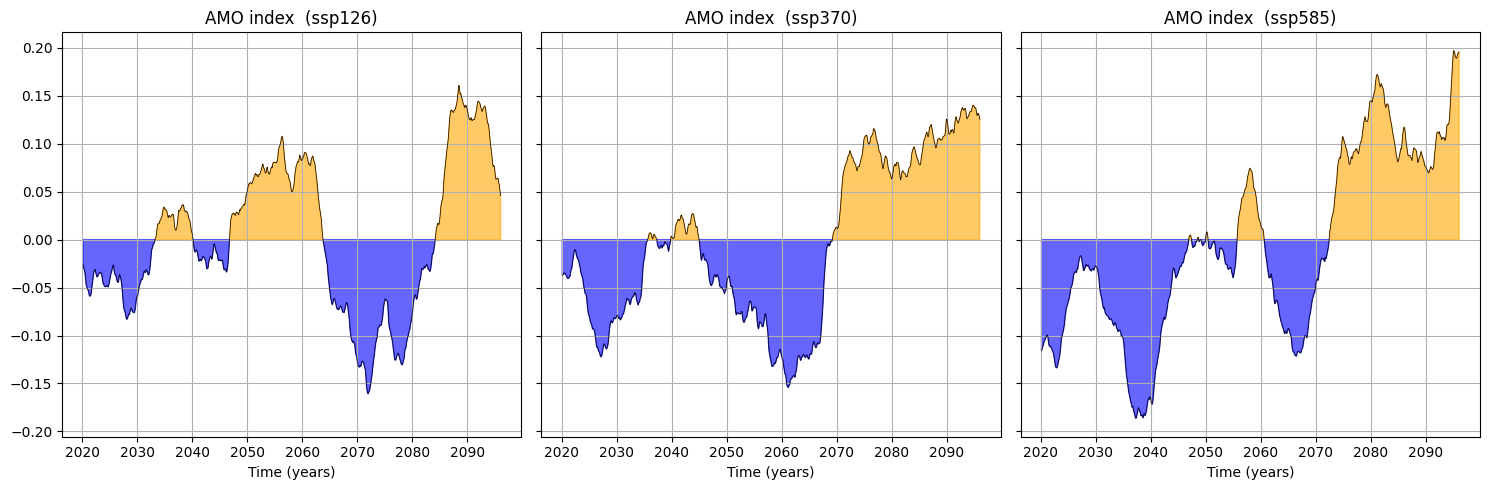

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

amo_data = [
    (amo_ix_126['time'].isel(time=slice(61, -59)), amo_126.squeeze(), "ssp126"),
    (amo_ix_370['time'].isel(time=slice(61, -59)), amo_370.squeeze(), "ssp370"),
    (amo_ix_585['time'].isel(time=slice(61, -59)), amo_585.squeeze(), "ssp585"),
]

for i, (time, data, label) in enumerate(amo_data):
    ax = axes[i]

    ax.fill_between(time, data, where=data > 0, color="orange", alpha=0.6)
    ax.fill_between(time, data, where=data <= 0, color="blue", alpha=0.6)

    ax.plot(time, data, color="black", linewidth=0.5)

    ax.set_title(f"AMO index  ({label})")
    ax.set_xlabel("Time (years)")
    ax.grid(True)


plt.tight_layout()
plt.show()

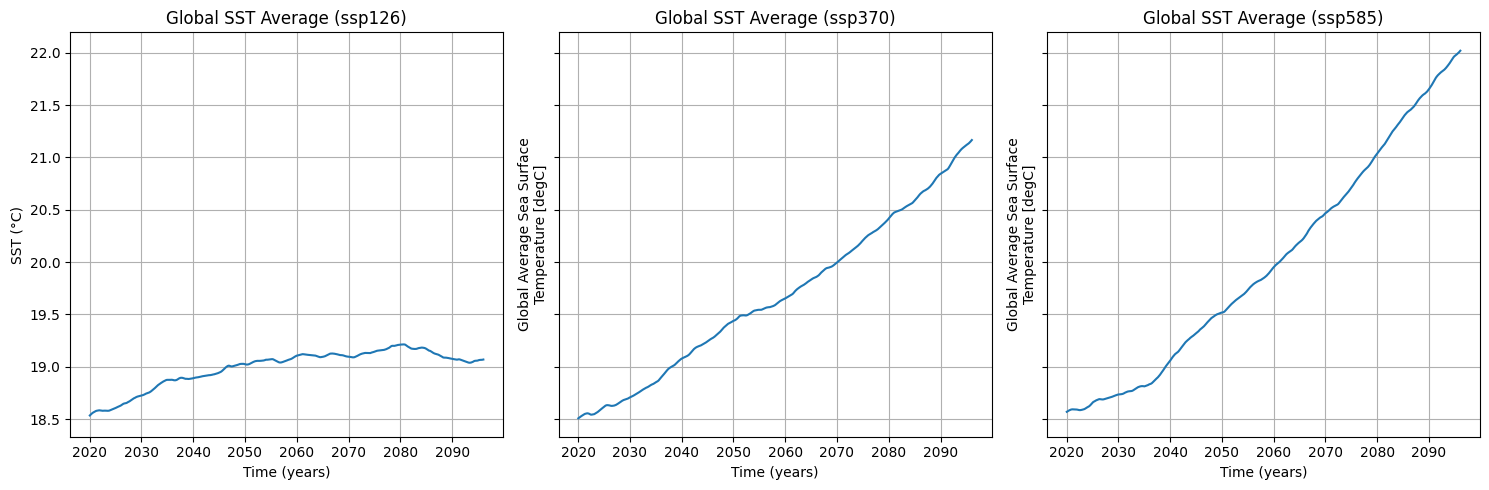

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

tosga_data = [
    (ipsl_ssp126_tosga_truncated.tosga, "ssp126"),
    (ipsl_ssp370_tosga_truncated.tosga, "ssp370"),
    (ipsl_ssp585_tosga_truncated.tosga, "ssp585"),
]

for i, (data, label) in enumerate(tosga_data):
    ax = axes[i]

    data.rolling(time=120, center=True).mean().plot(ax=ax)

    ax.set_title(f"Global SST Average ({label})")
    ax.set_xlabel("Time (years)")
    ax.grid(True)

axes[0].set_ylabel("SST (°C)")

plt.tight_layout()
plt.show()